T_stim (from stim_mat): 1197265
NT * n_trig:            1197265
FM_1 length:            65536
T_spk (from spike bins): 1199059
Y shape: (1199059, 31)
Using common length T = 1197265


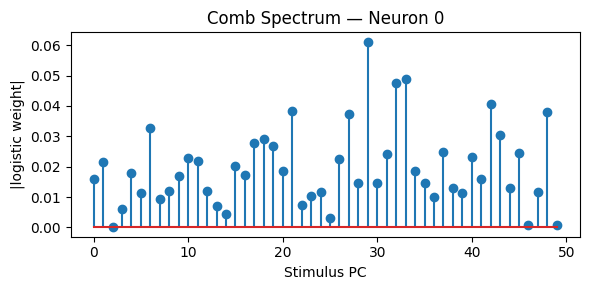

In [7]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ============================================================
# PATHS
# ============================================================

BASE = "/home/maria/ProjectionSort/mixed_selectivity_auditory/data"

STIM_MATRIX_PATH = f"{BASE}/Stimulus/rn1-matrix.mat"
STIM_PARAM_PATH  = f"{BASE}/Stimulus/rn1-param.mat"
DATA_PATH        = f"{BASE}/Data/site1-rn1.mat"

# ============================================================
# 1) LOAD STIMULUS MATRIX
# ============================================================

stim = sio.loadmat(STIM_MATRIX_PATH)
stim_mat = stim["stim_mat"]          # (freq, time)
X_stim = stim_mat.T                  # (time, freq)

# ============================================================
# 2) LOAD NEURAL DATA
# ============================================================

data = sio.loadmat(DATA_PATH, squeeze_me=True)
spk     = data["spk"]                # array of neurons (structs)
trigger = data["trigger"]            # trigger sample indices
fs      = 20000                      # Hz

n_trig = len(trigger)

# ============================================================
# 3) LOAD STIMULUS PARAMS
# ============================================================

param   = sio.loadmat(STIM_PARAM_PATH)
taxis_1 = param["taxis"].squeeze()   # (NT,) per trigger, in ms
FM_1    = param["FM"].squeeze()      # (NT,) per trigger
RD_1    = param["RD"].squeeze()      # (NT,) per trigger
NT      = int(param["NT"].item())

# Try to infer how stimulus matrix is organized
T_stim = X_stim.shape[0]             # timepoints in stim_mat
NT_times_trig = NT * n_trig

print(f"T_stim (from stim_mat): {T_stim}")
print(f"NT * n_trig:            {NT_times_trig}")
print(f"FM_1 length:            {FM_1.size}")

# Unfold FM/RD across triggers if needed
if FM_1.size == T_stim:
    FM = FM_1
elif FM_1.size * n_trig == T_stim:
    FM = np.tile(FM_1, n_trig)
else:
    # Fallback: tile and then truncate to T_stim
    FM = np.tile(FM_1, n_trig)
    FM = FM[:T_stim]

# Same for RD (even if we don't use it yet)
if RD_1.size == T_stim:
    RD = RD_1
elif RD_1.size * n_trig == T_stim:
    RD = np.tile(RD_1, n_trig)
else:
    RD = np.tile(RD_1, n_trig)
    RD = RD[:T_stim]

# ============================================================
# 4) BUILD TIME BINS FOR SPIKES
# ============================================================

dt = taxis_1[1] - taxis_1[0]   # ms per bin within a trigger

bin_edges = []
for t in trigger:
    start_ms = t / fs * 1000.0
    edges = start_ms + np.arange(NT + 1) * dt
    bin_edges.append(edges)

bin_edges = np.concatenate(bin_edges)   # length = NT * n_trig + 1
T_spk = bin_edges.size - 1              # number of bins for spikes

print(f"T_spk (from spike bins): {T_spk}")

# ============================================================
# 5) BIN SPIKES
# ============================================================

R = []
for neuron in spk:
    spkt = neuron["spiketimes"]        # ms
    counts, _ = np.histogram(spkt, bins=bin_edges)
    R.append(counts)

R = np.array(R)                        # (neurons, time)
Y = R.T                                # (time, neurons)

print(f"Y shape: {Y.shape}")          # (T_spk, n_neurons)

# ============================================================
# 6) ALIGN LENGTHS BY TRUNCATION
# ============================================================

T_common = min(T_stim, T_spk, FM.size)
print(f"Using common length T = {T_common}")

X_stim = X_stim[:T_common]
Y      = Y[:T_common]
FM     = FM[:T_common]

# Final sanity check (should pass)
assert X_stim.shape[0] == Y.shape[0] == FM.size

# ============================================================
# 7) PCA ON STIMULUS
# ============================================================

X = StandardScaler().fit_transform(X_stim)

n_pcs = min(50, X.shape[1])           # don't ask for more PCs than dims
pca = PCA(n_components=n_pcs)
X_pca = pca.fit_transform(X)

# ============================================================
# 8) TARGET (HIGH vs LOW TEMPORAL MODULATION)
# ============================================================

y = (FM > np.median(FM)).astype(int)

# ============================================================
# 9) LOGISTIC REGRESSION → COMB SPECTRUM
# ============================================================

def comb_spectrum(X, y):
    clf = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
    )
    clf.fit(X, y)
    beta = clf.coef_.squeeze()
    return np.abs(beta)

# ============================================================
# 10) EXAMPLE NEURON
# ============================================================

neuron_id = 0
y_neuron = (Y[:, neuron_id] > 0).astype(int)
spec = comb_spectrum(X_pca, y_neuron)

# ============================================================
# 11) PLOT
# ============================================================

plt.figure(figsize=(6, 3))
plt.stem(spec)
plt.xlabel("Stimulus PC")
plt.ylabel("|logistic weight|")
plt.title(f"Comb Spectrum — Neuron {neuron_id}")
plt.tight_layout()
plt.show()
